In [13]:
import duckdb
import pyarrow.dataset as ds
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]

In [2]:
dataset = ds.dataset("data/status", format="parquet", partitioning="hive")

In [3]:
con = duckdb.connect()
con = con.register("status", dataset)

In [4]:
station_ids = con.execute("select distinct(station_id) from status").df()["station_id"].values
len(station_ids)

472

In [5]:
dfs_to_concat = []
for station_id in station_ids[:15]:
    df_query = f"""
    WITH base_status AS (select
        station_id,
        hour,
        num_bikes_available,
        num_bikes_disabled,
        num_docks_available,
        num_docks_disabled,
        status,
        make_timestamp(year, month, day, hour, minute, 0.0) as ts,
    from
        status
    where
        station_id = {station_id} and
        status = 'IN_SERVICE')"""
    df_query += " union ".join([
    f"""
    select
        station_id,
        hour,
        dayofweek(ts) as dow,
        num_bikes_available,
        num_bikes_disabled,
        num_docks_available,
        num_docks_disabled,
        minute(lead(ts, {i}) over (
            order by ts asc
        ) - ts)  as minutes_bt_check,
        lead(num_bikes_available, {i}) over (
            order by ts asc
        ) as remaining_bikes_available,
    from
        base_status
    """ for i in range(1, 17)])
    dfs_to_concat.append(con.execute(df_query).df())

dataset_df = pd.concat(dfs_to_concat)

In [39]:
dataset_df.to_csv("minutes.csv", index=False)

In [6]:
dataset_df = pd.read_csv("minutes.csv")

In [3]:
len(dataset_df)

11482579

<AxesSubplot: xlabel='station_id', ylabel='count'>

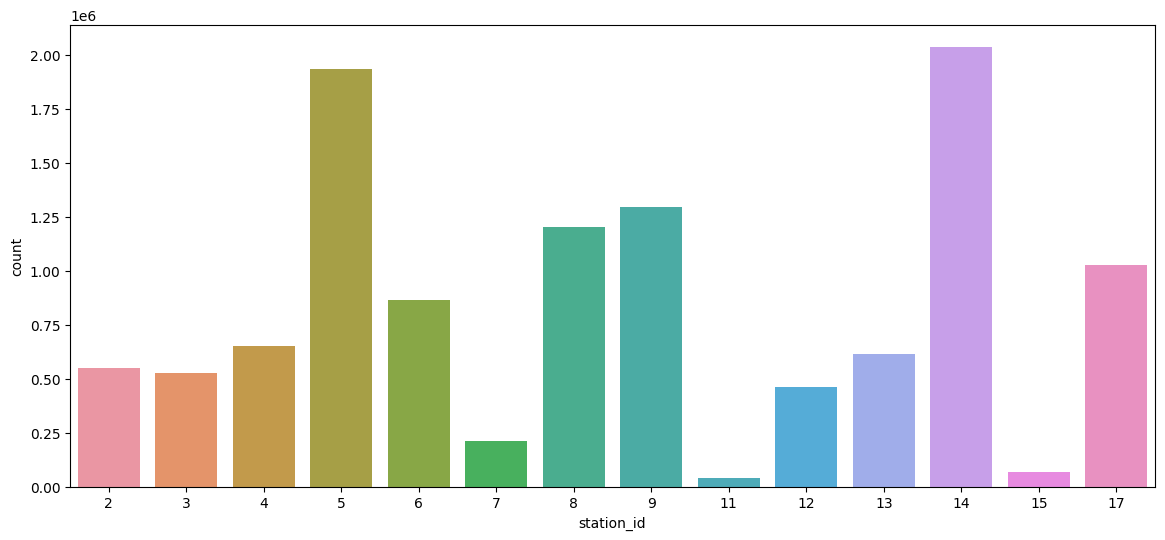

In [4]:
sns.countplot(dataset_df, x="station_id")

<AxesSubplot: xlabel='num_bikes_available', ylabel='Count'>

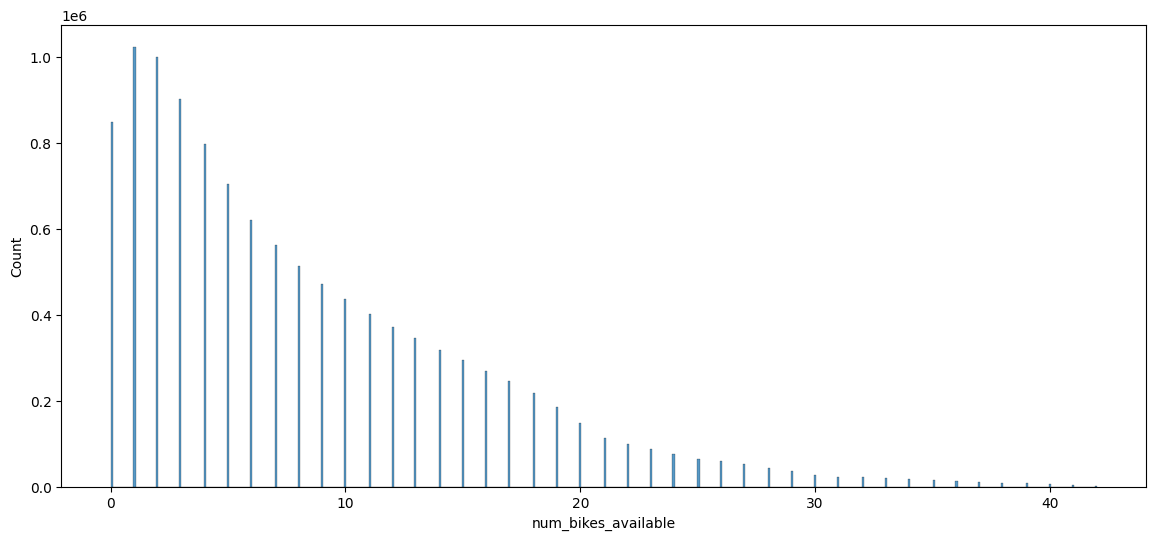

In [5]:
sns.histplot(dataset_df, x="num_bikes_available")

<AxesSubplot: xlabel='num_bikes_available', ylabel='remaining_bikes_available'>

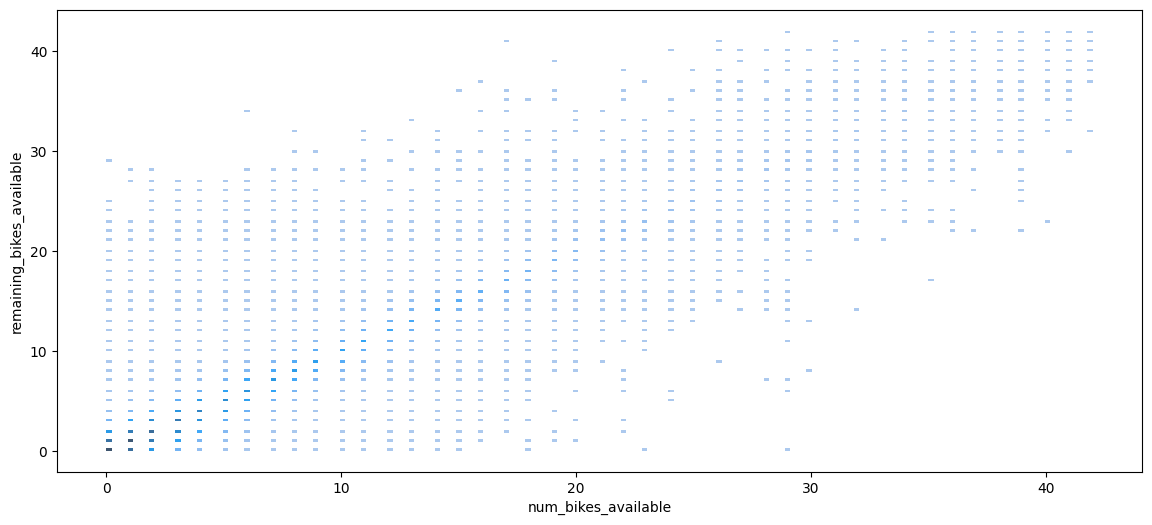

In [6]:
sns.histplot(dataset_df.sample(n=500000), x="num_bikes_available", y ="remaining_bikes_available")

In [3]:
dataset_df["bike_difference"] = dataset_df["num_bikes_available"] - dataset_df["remaining_bikes_available"]

<AxesSubplot: xlabel='bike_difference', ylabel='Count'>

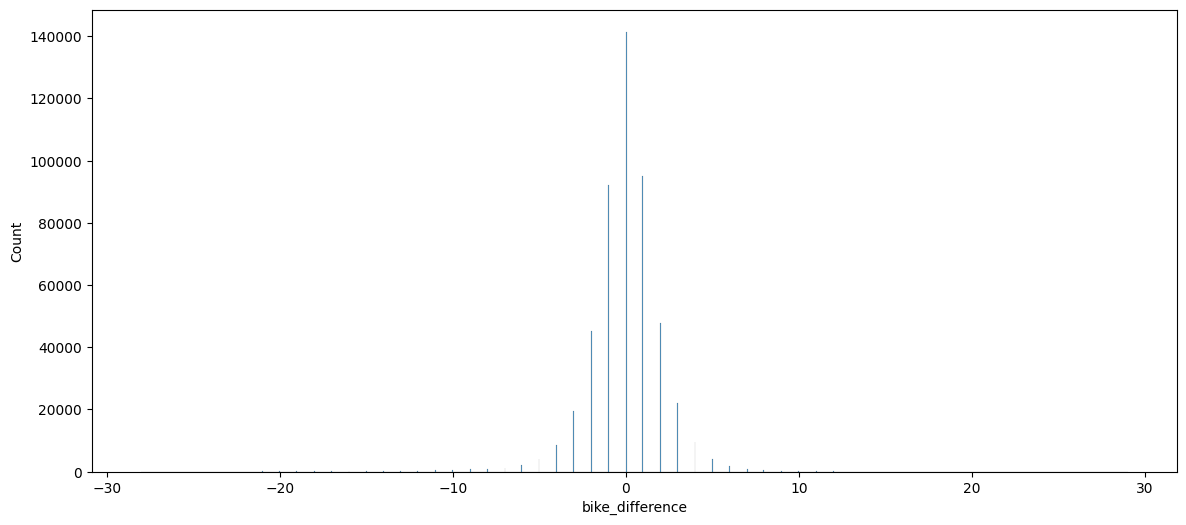

In [8]:
sns.histplot(dataset_df.sample(n=500000), x="bike_difference")

<AxesSubplot: xlabel='minutes_bt_check', ylabel='abs_bike_difference'>

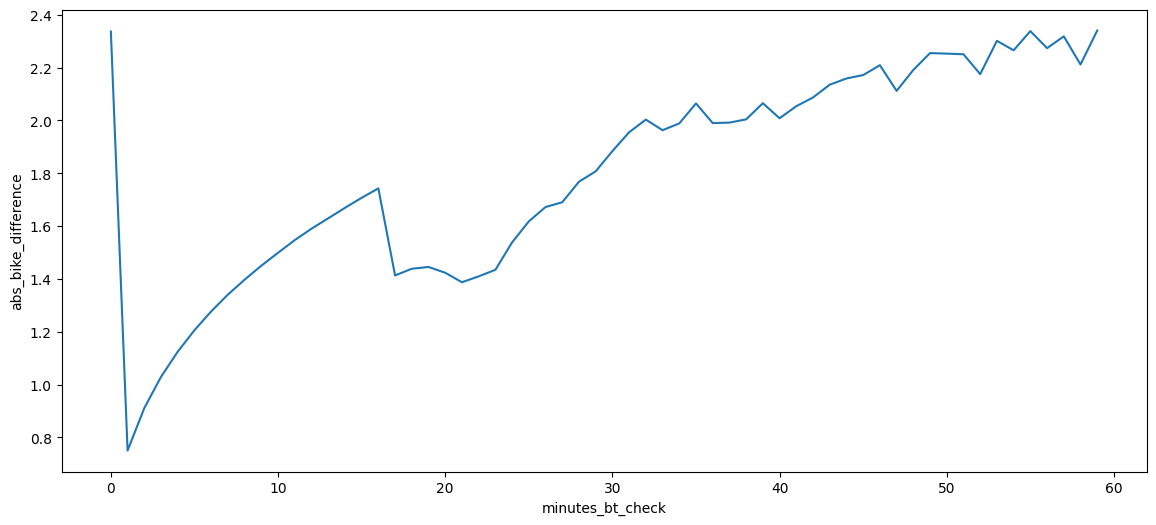

In [14]:
dataset_df["abs_bike_difference"] = np.absolute(dataset_df["bike_difference"])
dataset_df.groupby("minutes_bt_check")["abs_bike_difference"].mean().plot(ylabel="abs_bike_difference")

In [15]:
dataset_df["bike_variation"] =  (dataset_df["bike_difference"]>0).astype(int)

<AxesSubplot: xlabel='minutes_bt_check', ylabel='bike_variation'>

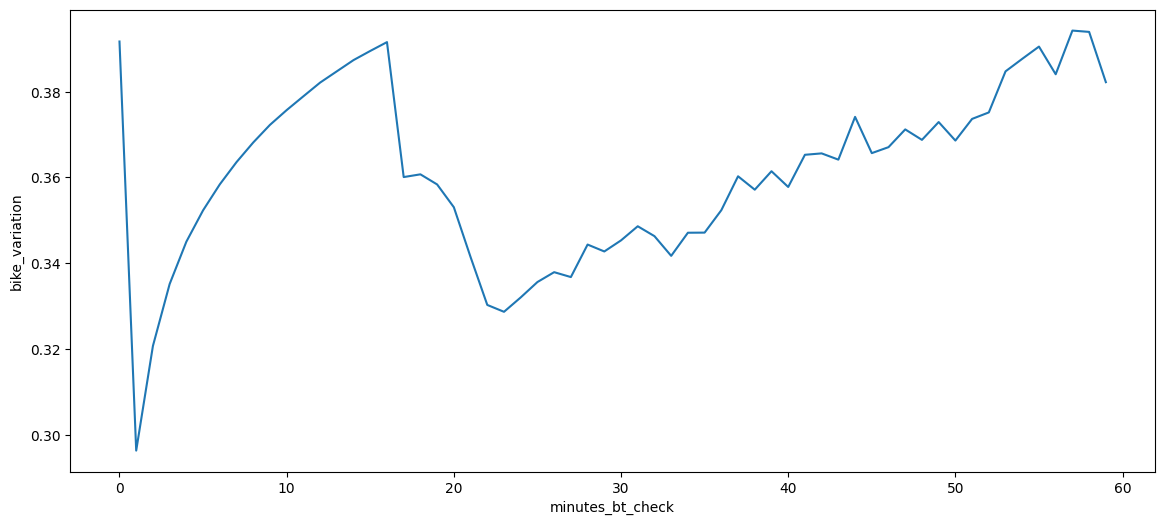

In [16]:
dataset_df.groupby("minutes_bt_check")["bike_variation"].mean().plot(ylabel="bike_variation")